<a href="https://colab.research.google.com/github/Stefi96/DetectingNFTs-Master/blob/main/Images_NFTs_Master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import os
import numpy as np
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [64]:
# Paths to all the scam and legit images
# NOTE: One option is the paths for google cloud and the other for running locally
scam_image_paths = [os.path.join("/content/drive/MyDrive/Master/Project/Images/Images_scam", image) for image in os.listdir("/content/drive/MyDrive/Master/Project/Images/Images_scam")]
legit_image_paths = [os.path.join("/content/drive/MyDrive/Master/Project/Images/Images_legit", image) for image in os.listdir("/content/drive/MyDrive/Master/Project/Images/Images_legit")]
#scam_image_paths = [os.path.join(r"C:\Users\stefanve\Desktop\Project\Images\Images_scam", image) for image in os.listdir(r"C:\Users\stefanve\Desktop\Project\Images\Images_scam")]
#legit_image_paths = [os.path.join(r"C:\Users\stefanve\Desktop\Project\Images\Images_legit", image) for image in os.listdir(r"C:\Users\stefanve\Desktop\Project\Images\Images_legit")]

In [65]:
import os

# Paths to your scam and legit images on Google Drive
scam_dir = "/content/drive/MyDrive/Master/Project/Images/Images_scam"
legit_dir = "/content/drive/MyDrive/Master/Project/Images/Images_legit"

# List the images in the directories
scam_images = os.listdir(scam_dir)
legit_images = os.listdir(legit_dir)

# Print the number of images detected in each directory
print(f"Number of scam images detected: {len(scam_images)}")
print(f"Number of legit images detected: {len(legit_images)}")

Number of scam images detected: 1082
Number of legit images detected: 1762


In [66]:
def try_loading_images(image_paths):
    loaded_images = []
    for img_path in image_paths[:10]:  # Limiting to the first 10 images for testing
        try:
            img = Image.open(img_path).resize((128, 128))
            img_array = np.array(img) / 255.0
            loaded_images.append(img_array)
        except Exception as e:
            print(f"Error with image {img_path}: {e}")
    return loaded_images

# Attempt to load and process a subset of scam and legit images
loaded_scam_images = try_loading_images(scam_image_paths)
loaded_legit_images = try_loading_images(legit_image_paths)

print(f"Number of scam images loaded: {len(loaded_scam_images)}")
print(f"Number of legit images loaded: {len(loaded_legit_images)}")

Number of scam images loaded: 10
Number of legit images loaded: 10


In [67]:
def load_and_preprocess_images_modified(image_paths, label):
    data = []
    labels = []
    for img_path in image_paths:
        try:
            # Open the image and convert to RGB (removing any alpha channel)
            img = Image.open(img_path).convert("RGB").resize((128, 128))
            img_array = np.array(img) / 255.0
            data.append(img_array)
            labels.append(label)
        except Exception as e:
            print(f"Error with image {img_path}: {e}")
    return data, labels

# Load and preprocess the images using the modified function
scam_data, scam_labels = load_and_preprocess_images_modified(scam_image_paths, "scam")
legit_data, legit_labels = load_and_preprocess_images_modified(legit_image_paths, "legit")

# Combine data and labels
all_data = scam_data + legit_data
all_labels = scam_labels + legit_labels

print(f"Total number of images in all_data: {len(all_data)}")
print(f"Total number of labels in all_labels: {len(all_labels)}")

Total number of images in all_data: 2844
Total number of labels in all_labels: 2844


In [62]:
# Use the debug function to load and preprocess images
scam_data, scam_labels = load_and_preprocess_images_modified(scam_image_paths, "scam")
legit_data, legit_labels = load_and_preprocess_images_modified(legit_image_paths, "legit")

In [68]:
all_data = scam_data + legit_data
all_labels = scam_labels + legit_labels

print(f"Total number of images in all_data: {len(all_data)}")
print(f"Total number of labels in all_labels: {len(all_labels)}")

Total number of images in all_data: 2844
Total number of labels in all_labels: 2844


In [69]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(all_data, all_labels, test_size=0.3, random_state=42, stratify=all_labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training data size: {len(X_train)}")
print(f"Validation data size: {len(X_val)}")
print(f"Test data size: {len(X_test)}")

Training data size: 1990
Validation data size: 427
Test data size: 427


In [70]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)


In [71]:
y_train = to_categorical(y_train, 2)
y_val = to_categorical(y_val, 2)
y_test = to_categorical(y_test, 2)

In [72]:
input_shape = (128, 128, 3)
# model = Sequential()
# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(2, activation='softmax'))

# Adding dropout layers
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [73]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [74]:
# Adding early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

In [75]:
# Implementing data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [76]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

In [77]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (1990, 128, 128, 3)
y_train shape: (1990, 2)
X_val shape: (427, 128, 128, 3)
y_val shape: (427, 2)


In [78]:
number_of_epochs = 50  # Adjust this based on your requirements
history = model.fit(datagen.flow(np.array(X_train), np.array(y_train), batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=number_of_epochs,
                    callbacks=[early_stop])
#history = model.fit(np.array(X_train), np.array(y_train), epochs=10, batch_size=32, validation_data=(np.array(X_val), np.array(y_val)), callbacks=[early_stop])

Epoch 1/50
63/63 [==============================] - 12s 157ms/step - loss: 0.3965 - accuracy: 0.8754 - val_loss: 0.3176 - val_accuracy: 0.8852
Epoch 2/50
63/63 [==============================] - 10s 156ms/step - loss: 0.1771 - accuracy: 0.9452 - val_loss: 0.2076 - val_accuracy: 0.9251
Epoch 3/50
63/63 [==============================] - 8s 124ms/step - loss: 0.1733 - accuracy: 0.9492 - val_loss: 0.1788 - val_accuracy: 0.9415
Epoch 4/50
63/63 [==============================] - 9s 140ms/step - loss: 0.1463 - accuracy: 0.9553 - val_loss: 0.1470 - val_accuracy: 0.9649
Epoch 5/50
63/63 [==============================] - 10s 160ms/step - loss: 0.1376 - accuracy: 0.9568 - val_loss: 0.1363 - val_accuracy: 0.9578
Epoch 6/50
63/63 [==============================] - 12s 189ms/step - loss: 0.1094 - accuracy: 0.9613 - val_loss: 0.1258 - val_accuracy: 0.9672
Epoch 7/50
63/63 [==============================] - 10s 158ms/step - loss: 0.1200 - accuracy: 0.9613 - val_loss: 0.1384 - val_accuracy: 0.9602
E

In [79]:
test_loss, test_acc = model.evaluate(np.array(X_test), np.array(y_test))
print(f"Test accuracy: {test_acc}")

14/14 [==============================] - 0s 10ms/step - loss: 0.0520 - accuracy: 0.9813
Test accuracy: 0.9812646508216858


In [80]:
print(f"Original X_test shape: {np.array(X_test).shape}")

# Reshape if necessary
X_test_reshaped = np.array(X_test).reshape(-1, 128, 128, 3)  # Assuming your images are 128x128 and RGB
print(f"Reshaped X_test shape: {X_test_reshaped.shape}")

Original X_test shape: (427, 128, 128, 3)
Reshaped X_test shape: (427, 128, 128, 3)


In [81]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Predict the labels for the test set using reshaped data
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

# ROC-AUC
# Note: This is for binary classification. If your task is multi-class, this will need adjustments.
roc_auc = roc_auc_score(y_true, y_pred_classes)
print(f"\nROC-AUC: {roc_auc:.4f}")


14/14 [==============================] - 0s 7ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       265
           1       0.98      0.97      0.98       162

    accuracy                           0.98       427
   macro avg       0.98      0.98      0.98       427
weighted avg       0.98      0.98      0.98       427


Confusion Matrix:
[[262   3]
 [  5 157]]

ROC-AUC: 0.9789


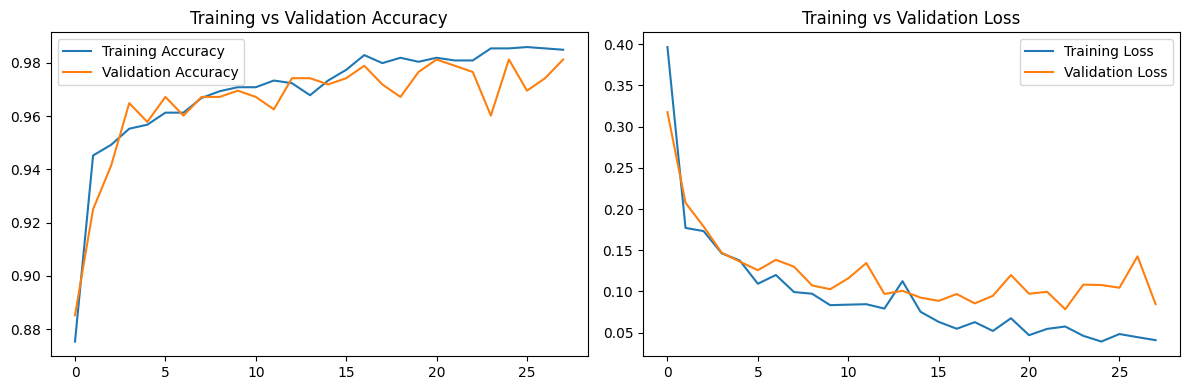

In [82]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

# Plotting training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.tight_layout()
plt.show()